# Word Graph

In [17]:
!pip install PyPDF2 nltk networkx pandas matplotlib tqdm
!pip install Sastrawi
import os, re, math
from collections import Counter
from itertools import combinations
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [18]:
import PyPDF2
import re
import nltk
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

nltk.download("punkt")  # sekali saja

# --- baca PDF ---
def read_pdf(path):
    pages = []
    with open(path, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        for p in reader.pages:
            t = p.extract_text()
            if t:
                pages.append(t)
    return "\n".join(pages)

# GANTI path kalau perlu
pdf_text = read_pdf("Data/Papper_Gempa.pdf")

print("Panjang teks mentah:", len(pdf_text))
print(pdf_text[:500])


[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Panjang teks mentah: 22087
 
DRR Action Plan Workshop: Strengthened Indonesian  
Resilience: Reducing Risk from Disasters  
 
 
Bencana  Gempabumi  
Salahuddin Husein  
Depart emen Teknik Geologi , Fakultas Teknik, Universitas Gadjah Mada  
email: shddin @gmail.com  
 
Abstract:   
Bencana gempabumi di Indonesia adalah suatu keniscayaan, tidak hanya pada daerah 
yang selama ini diketahui seringkali mengalaminya, namun juga pada daerah yang dahulu diduga 
relatif aman. Kondisi demikian dikontrol oleh konfigurasi tektonis I


In [19]:
import re
import nltk
import pandas as pd
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('punkt', quiet=True)

# ---------------------------------------------------------
# 1. CLEANING TEKS
# ---------------------------------------------------------
def clean_text(text):
    cut = re.search(r"(DAFTAR PUSTAKA|REFERENSI|References|Bibliographie)",
                    text, re.IGNORECASE)
    if cut:
        text = text[:cut.start()]
    text = re.sub(r"\s+", " ", text)
    return text.strip()

cleaned = clean_text(pdf_text)

print("Panjang teks cleaned:", len(cleaned))
print(cleaned[:500])

# ---------------------------------------------------------
# 2. MEMECAH TEKS MENJADI KALIMAT (>=10 KATA)
# ---------------------------------------------------------
sentences_raw = sent_tokenize(cleaned)
sentences_raw = [re.sub(r"\s+", " ", s).strip() for s in sentences_raw if s.strip() != ""]

sentences = [s for s in sentences_raw if len(s.split()) >= 10]

df_sent = pd.DataFrame({"sentence": sentences})
csv_path = "sentences.csv"
df_sent.to_csv(csv_path, index=False, encoding="utf-8")

print(f"\nJumlah kalimat dipakai (>=10 kata): {len(sentences)}")

# ---------------------------------------------------------
# 3. TOKENISASI KATA
# ---------------------------------------------------------
tokens = word_tokenize(cleaned.lower())

# ---------------------------------------------------------
# 4. EKSTRAKSI KATA BERSIH (hapus angka & simbol)
# ---------------------------------------------------------
# hapus ANGGKA, SIMBOL, TANDA BACA
words = [re.sub(r"[^a-zA-Z]", "", w) for w in tokens]

# buang string kosong
words = [w for w in words if w != ""]

# buang kata sangat pendek (1 huruf) karena biasanya noise
words = [w for w in words if len(w) > 1]

# cek kembali tidak ada angka atau simbol
words = [w for w in words if w.isalpha()]

# ---------------------------------------------------------
# 5. STOPWORD REMOVAL (SASTRAWI)
# ---------------------------------------------------------
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
factory = StopWordRemoverFactory()
stopwords = set(factory.get_stop_words())

words = [w for w in words if w not in stopwords]

# ---------------------------------------------------------
# 6. PERBAIKAN KATA TERPISAH (OCR FIX)
# ---------------------------------------------------------
def merge_simple(tokens, vocab_set):
    merged = []
    i = 0
    while i < len(tokens):
        if i+1 < len(tokens):
            cand = tokens[i] + tokens[i+1]
            if cand in vocab_set:
                merged.append(cand)
                i += 2
                continue
        merged.append(tokens[i])
        i += 1
    return merged

vocab_merge = {"departemen"}
words = merge_simple(words, vocab_merge)

# ---------------------------------------------------------
# 7. OUTPUT
# ---------------------------------------------------------
print("\nTotal kata setelah semua cleaning:", len(words))
print("100 kata pertama:", words[:100])


Panjang teks cleaned: 20927
DRR Action Plan Workshop: Strengthened Indonesian Resilience: Reducing Risk from Disasters Bencana Gempabumi Salahuddin Husein Depart emen Teknik Geologi , Fakultas Teknik, Universitas Gadjah Mada email: shddin @gmail.com Abstract: Bencana gempabumi di Indonesia adalah suatu keniscayaan, tidak hanya pada daerah yang selama ini diketahui seringkali mengalaminya, namun juga pada daerah yang dahulu diduga relatif aman. Kondisi demikian dikontrol oleh konfigurasi tektonis Indonesia di masa lampa u d

Jumlah kalimat dipakai (>=10 kata): 116

Total kata setelah semua cleaning: 2012
100 kata pertama: ['drr', 'action', 'plan', 'workshop', 'strengthened', 'indonesian', 'resilience', 'reducing', 'risk', 'from', 'disasters', 'bencana', 'gempabumi', 'salahuddin', 'husein', 'departemen', 'teknik', 'geologi', 'fakultas', 'teknik', 'universitas', 'gadjah', 'mada', 'email', 'shddin', 'gmailcom', 'abstract', 'bencana', 'gempabumi', 'indonesia', 'suatu', 'keniscayaan', 'daera

In [20]:
from itertools import zip_longest

G = nx.Graph()

# tambahkan node
for w in words:
    if not G.has_node(w):
        G.add_node(w)

# tambahkan edge untuk pasangan bertetangga (distance = 1)
for w1, w2 in zip(words, words[1:]):
    if w1 == "" or w2 == "":
        continue
    if G.has_edge(w1, w2):
        # boleh pakai weight kalau mau tahu seberapa sering
        G[w1][w2]["weight"] += 1
    else:
        G.add_edge(w1, w2, weight=1)

print("Jumlah node (kata):", G.number_of_nodes())
print("Jumlah edge (pasangan tetangga):", G.number_of_edges())


Jumlah node (kata): 797
Jumlah edge (pasangan tetangga): 1694


In [21]:
from collections import Counter

# hitung frekuensi kata untuk pilih N terbesar
freq = Counter(words)
N = 100

# ambil N kata paling sering
top_vocab = [w for w, c in freq.most_common(N)]
print("Kata yang dipakai di matriks:", top_vocab)

# buat indeks
idx = {w: i for i, w in enumerate(top_vocab)}

# inisialisasi matriks 0
A = np.zeros((N, N), dtype=int)

# isi matriks: kalau ada edge di graph → 1
for u, v in G.edges():
    if u in idx and v in idx:
        i, j = idx[u], idx[v]
        A[i, j] = 1
        A[j, i] = 1   # graph tak berarah

adj_df = pd.DataFrame(A, index=top_vocab, columns=top_vocab)

# --- Degree Centrality ---
import networkx as nx
import pandas as pd

deg_cent = nx.degree_centrality(G)

# ambil hanya kata yang muncul di matriks
deg_df = pd.DataFrame.from_dict(deg_cent, orient='index', columns=['degree_centrality'])
deg_df = deg_df.loc[top_vocab]
deg_df = deg_df.sort_values('degree_centrality', ascending=False)

print("Degree Centrality untuk kata:")

from IPython.display import display

display(adj_df)   # tampilkan adjacency matrix
display(deg_df)   # tampilkan degree centrality


Kata yang dipakai di matriks: ['gempabumi', 'gelombang', 'patahan', 'bangunan', 'batuan', 'besar', 'bidang', 'perioda', 'permukaan', 'terjadi', 'gambar', 'gempa', 'skala', 'magnitudo', 'jenis', 'bila', 'bergerak', 'lebih', 'pergeseran', 'energi', 'merambat', 'tersebut', 'getaran', 'lempeng', 'indonesia', 'berbagai', 'peristiwa', 'korban', 'satu', 'detik', 'bencana', 'baik', 'seismik', 'suatu', 'daerah', 'menjadi', 'mampu', 'frekuensi', 'memiliki', 'gaya', 'atas', 'hingga', 'meninggal', 'disebut', 'per', 'material', 'banyak', 'beberapa', 'kerusakan', 'akselerasi', 'seluruh', 'sepanjang', 'bumi', 'tanah', 'siklus', 'horisontal', 'maupun', 'cepat', 'resonansi', 'interaksi', 'jumlah', 'orang', 'arah', 'vertikal', 'primer', 'kecepatan', 'geologi', 'selama', 'informasi', 'intensitas', 'senantiasa', 'faktor', 'tempat', 'dekat', 'mengalami', 'umumnya', 'blok', 'bergeser', 'muncul', 'paling', 'jarak', 'panjang', 'badan', 'tektonis', 'benda', 'sangat', 'bawah', 'akurat', 'disebabkan', 'menentuka

,gempabumi,gelombang,patahan,bangunan,batuan,besar,bidang,perioda,permukaan,terjadi,...,amplifikasi,generasi,berada,menggeser,akibat,yogyakarta,perlu,peta,longsor,lainnya
gempabumi,1,1,1,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
gelombang,1,1,0,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
patahan,1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bangunan,0,1,0,0,0,0,0,1,1,0,...,0,0,1,0,1,0,0,0,0,0
batuan,0,0,0,0,0,0,0,1,1,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yogyakarta,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
perlu,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
peta,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
longsor,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


,degree_centrality
gempabumi,0.114322
gelombang,0.089196
patahan,0.072864
bangunan,0.056533
besar,0.042714
...,...
bawah,0.007538
amplifikasi,0.006281
badan,0.006281
meninggal,0.005025


In [22]:
pr = nx.pagerank(G, weight="weight")  # pakai bobot berapa sering jadi tetangga

# urutkan dari yang terbesar
pr_sorted = sorted(pr.items(), key=lambda x: x[1], reverse=True)

# tampilkan kata penting
top_pr = pr_sorted[:30]
pr_df = pd.DataFrame(top_pr, columns=["Kata", "PageRank"])
pr_df


,Kata,PageRank
0,gempabumi,0.026955
1,gelombang,0.022269
2,patahan,0.019362
3,bangunan,0.011402
4,batuan,0.008199
5,besar,0.007966
6,bidang,0.006811
7,perioda,0.006804
8,terjadi,0.006729
9,gempa,0.006539


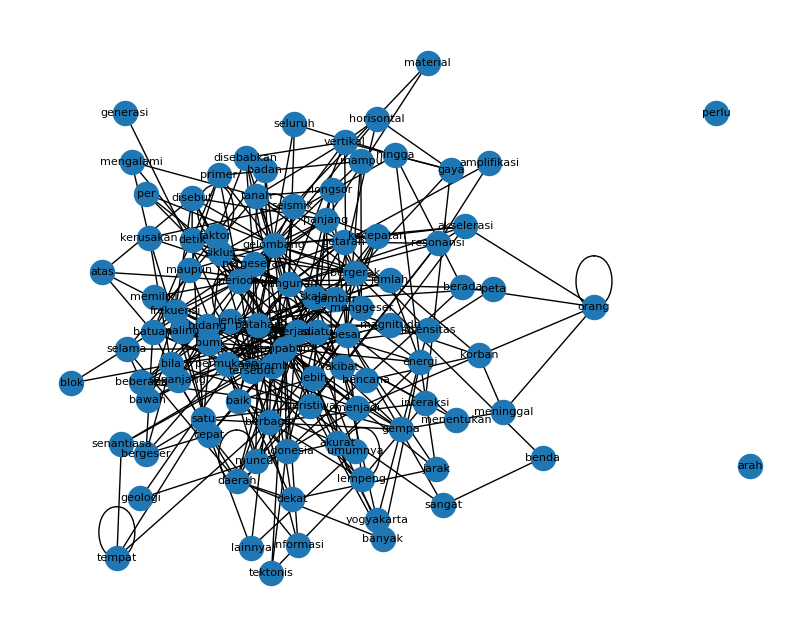

In [23]:
plt.figure(figsize=(10, 8))

subG = G.subgraph(top_vocab)
pos = nx.spring_layout(subG, k=0.4)

nx.draw_networkx_nodes(subG, pos)
nx.draw_networkx_edges(subG, pos)
nx.draw_networkx_labels(subG, pos, font_size=8)

plt.axis("off")
plt.show()
